# Machine Annotation - Round 1 - BERTimbau - Relevance


---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Hugging Face - Transformers


In [3]:
!pip install transformers

### Libraries

In [4]:
import transformers
from transformers import BertForSequenceClassification, BertTokenizer, pipeline
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, random_split, Subset, RandomSampler, SequentialSampler, Dataset
import sklearn
from sklearn.model_selection import train_test_split
import os
import torch
import seaborn as sns
import random
import gc


In [82]:
def print_package_versions():
    print(f"Transformers version: {transformers.__version__}")
    print(f"Pandas version: {pd.__version__}")
    print(f"Numpy version: {np.__version__}")
    print(f"PyTorch version: {torch.__version__}")
    print(f"Scikit-learn version: {sklearn.__version__}")
    print(f"Seaborn version: {sns.__version__}")

In [83]:
print_package_versions()

Transformers version: 4.41.2
Pandas version: 2.0.3
Numpy version: 1.25.2
PyTorch version: 2.3.0+cu121
Scikit-learn version: 1.2.2
Seaborn version: 0.13.1


## Dataset - Relevance

---

**CHANGE FILE PATH HERE TO TRAIN WITH A DIFFERENT DATASET:**

In [7]:
# Pandas option
pd.set_option('display.max_columns', None)


# Dataset
df = pd.read_csv('/content/drive/MyDrive/Tweets and Vaccine (Backup)/Eliza Project/relevant_tweets_2020-12-31.csv')

df

,tweet_id,content,post_date,relevance
0,A522,A cabeça pensa onde o pé pisa. Quem governa de...,2020-09-15,relevant
1,A457,Sarto vai fazer um grande Programa de Enfrenta...,2020-11-20,relevant
2,A445,A Câmara dos Deputados votou hoje a MP que tra...,2020-12-18,relevant
3,A546,Tirar Bolsonaro do poder é uma questão de vida...,2020-11-10,relevant
4,A847,E a LIESA decidiu adiar os desfiles do #Carnav...,2020-09-24,relevant
...,...,...,...,...
2997,B2717,"""Estou exigindo a questão da cloroquina."" Algu...",2020-05-14,relevant
2998,B4586,#FeijoadaBeneficente | Participei neste sábado...,2020-03-09,irrelevant
2999,B4134,Aracaju tem um legado. Legado de desenvolvimen...,2020-06-10,irrelevant
3000,B2705,Estudo publicado pelo Imperial College estima ...,2020-04-01,irrelevant


**GLOBAL VARIABLES FOR COLUMN NAMES** \\
RELEVANCE = name of column representing relevance \\
RELEVANCE_ID = column value that represents (relevance == True) \\

POST = name of column representing the content of the tweet \\
POST_DATA = name of column representing the post date \\
POST_ID = name of column representing the tweet id

In [8]:
RELEVANCE = 'relevance'
RELEVANCE_ID = 'relevant'

POST = 'content'
POST_DATE = 'post_date'
POST_ID = 'tweet_id'

In [9]:
print(df[RELEVANCE].dtype, df[POST].dtype)

# print("\nrelevance column:\n",df20[RELEVANCE])

# print("\npost column:\n", df20[POST])

object object


In [10]:
print("Tweet_Relevancies 2020:")

print(df[RELEVANCE].value_counts())

# Class Distribution

Tweet_Relevancies 2020:
relevance
irrelevant    1595
relevant      1407
Name: count, dtype: int64


###  Parsing

In [11]:

#  Transforming Relevance into an integer

def condition(x):
    if x == RELEVANCE_ID:
        return 1
    else:
        return 0

df[RELEVANCE] = df[RELEVANCE].apply(condition)

# Class Distributions

print(df[RELEVANCE].value_counts())

relevance
0    1595
1    1407
Name: count, dtype: int64


### Train Test Set Split

Here, we separate 10% of the total observations for the test set. \\

Train and Test sets should be tokenized and processed separately to avoid data leakage. \\

We also used a stratifier for the split to ensure that there is a proportionality of classes over train and test (and, futhermore, on the validation sets).

In [12]:

df_train, df_test = train_test_split(df,
                                     test_size = 0.1, # 10% for the test set
                                     stratify = df[RELEVANCE], # Strat
                                     random_state = 42)

print("training set class distribution:")
print(df_train[RELEVANCE].value_counts())
print("\ntest set class distribution:")
print(df_test[RELEVANCE].value_counts())

training set class distribution:
relevance
0    1435
1    1266
Name: count, dtype: int64

test set class distribution:
relevance
0    160
1    141
Name: count, dtype: int64


## Model Configs, Dataloader and Training


---

Here we have the main hyperparameters and configurations of the model. \\

If you'd like, you can tweak the learning rate (L_RATE), maximum length of the vectors (MAX_LEN), Batch Size and the EPS of the Adam Otimizer. I think the number of folds and epochs will mostly remain the same. \\
 \\
**eps (float, optional)** – term added to the denominator to improve numerical stability (default: 1e-8)

### Configs

In [13]:

# BERTimbau
MODEL_TYPE = 'neuralmind/bert-base-portuguese-cased'


# Configs
NUM_FOLDS = 5
NUM_FOLDS_TO_TRAIN = 5

L_RATE = 2e-5 # Testar novos valores
MAX_LEN = 256 # Testar novos valores
BATCH_SIZE = 32
EPS = 1e-8

NUM_EPOCHS = 5
NUM_CORES = os.cpu_count()

NUM_CORES

2

GPU

In [14]:
# If there's a GPU available:
if torch.cuda.is_available():

    # Use GPU
    device = torch.device("cuda")

    print("There are available GPU(s).") # torch.cuda.device_cour

    print("We will use the GPU:", torch.cuda.get_device_name(0))

# If not

else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")

There are available GPU(s).
We will use the GPU: Tesla T4


### BERTimbau Tokenizer

In [15]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE, do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

### Creating the Dataloader


#### Dataset Custom Classes

In [16]:
# back to OG:


class CompDataset(Dataset):

  def __init__(self, df):
    self.df_data = df


  def __getitem__(self, index):

    # Get the sentences from the dataframe
    sentence = self.df_data.loc[index, POST]


    # Transform the sentence

    encoded_dict = tokenizer.encode_plus(sentence,  # Sentences to be tokenized
                                         add_special_tokens = True, # [CLS] and [SEP]
                                         padding = 'max_length',
                                         max_length = MAX_LEN,
                                         return_attention_mask = True, # Build attn. masks.
                                         return_tensors = 'pt', # Return pytorch tensors
                                        )


    # Torch Tensors

    padded_token_list = encoded_dict['input_ids'][0]
    att_mask = encoded_dict['attention_mask'][0]
    token_type_ids = encoded_dict['token_type_ids'][0]


    # Transforming the Target into a tensor

    target = torch.tensor(self.df_data.loc[index, RELEVANCE])

    sample = (padded_token_list, att_mask, token_type_ids, target)

    return sample


  def __len__(self):

    return len(self.df_data)



# Doing the same for the test dataset

class TestDataset(Dataset):

  def __init__(self, df):
    self.df_data = df


  def __getitem__(self, index):

    #  Get the sentences from the dataframe
    sentence = self.df_data.iloc[index, self.df_data.columns.get_loc(POST)]


    # Transform the sentence

    encoded_dict = tokenizer.encode_plus(sentence,  # Sentences to be tokenized
                                         add_special_tokens = True, # [CLS] and [SEP]
                                         padding = 'max_length',
                                         max_length = MAX_LEN,
                                         return_attention_mask = True, # attn. masks.
                                         return_tensors = 'pt', # Return Pytorch Tensors
                                        )


    padded_token_list = encoded_dict['input_ids'][0]
    att_mask = encoded_dict['attention_mask'][0]
    token_type_ids = encoded_dict['token_type_ids'][0]


    # Transforming the target into a tensor

    target = torch.tensor(self.df_data.iloc[index, self.df_data.columns.get_loc(RELEVANCE)])

    sample = (padded_token_list, att_mask, token_type_ids, target)

    return sample


  def __len__(self):

    return len(self.df_data)

## Model


---

Here is the model used for training (you can check the name of the model on the MODEL_TYPE variable). Don't forget to adjust the number of labels if you need.

In [17]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    MODEL_TYPE,
    num_labels = 2, # Change the number of classes accordingly
    output_attentions = False)

# Send the model to the device.
model.to(device)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#### Metrics

Main metrics used here are the classification report (which outputs precision, recall and f1-score per class) and the overall accuracy. We also computate the f1-macro on the training loop.

In [18]:
# Metrics

from sklearn.metrics import accuracy_score, f1_score, classification_report

# Accuracy

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Classification report
def classification_report_with_accuracy_score(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    report = classification_report(labels, pred_flat, output_dict = True, zero_division = 0)
    df_class_report = pd.DataFrame(report).transpose()
    return df_class_report

#### Training the model

In [19]:
from transformers import AdamW
import random
import gc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import shuffle

# Remove Warning

from transformers import logging

logging.set_verbosity_warning()



# Set a seed value.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Num folds
NUM_FOLDS_TO_TRAIN = 5
NUM_FOLDS = 5


# Kfold
skf = StratifiedKFold(n_splits = 5,
                     shuffle = True,
                     random_state = 42)

y = df_train[RELEVANCE]



Here is the code that will do the training of the model, read it carefully and you can ask me questions if needed.

In [20]:
%%time

# Create a list of lists to store the val. results.

fold_val_acc_list = []
fold_val_f1macro_list = []
training_stats = []
clf_report = pd.DataFrame()

# Training Loop

for i in range(0, NUM_FOLDS):

    # append an empty list
    fold_val_acc_list.append([])
    fold_val_f1macro_list.append([])



for fold_index, (train_index, val_index) in enumerate(skf.split(df_train,y)):

  print("\nNum folds used for training:", NUM_FOLDS_TO_TRAIN)
  print('\n################## Fold Model Number', fold_index, '##################')

  # ...........................................................................
  # Defining Dataloaders of Training and Validation
  # ...........................................................................


  # Train and Validation Sets
  train = df_train.iloc[train_index,:]
  val = df_train.iloc[val_index,:]


  # Reseting Indexes so it will work
  train_res = train.reset_index(drop = True)
  val_res = val.reset_index(drop = True)


  # Tokenizing and Transforming Inputs (att masks, labels, etc.)
  train_data = CompDataset(train_res)
  val_data = CompDataset(val_res)

  # Creating Dataloaders for this Fold/Run
  train_dataloader = torch.utils.data.DataLoader(train_data,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=True,
                                                   num_workers=NUM_CORES)

  val_dataloader = torch.utils.data.DataLoader(val_data,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 num_workers=NUM_CORES)


#------------------------------------------------------------------------------
  for epoch in range(0, NUM_EPOCHS):
#------------------------------------------------------------------------------

    #......................
    # Loading Fold Model
    #......................

    if epoch == 0:

      # Defining the model
      model = BertForSequenceClassification.from_pretrained(
          MODEL_TYPE,
          num_labels = 2,
          output_attentions = False,
          output_hidden_states = False,
          )

      # Send the model to the device.

      model.to(device)

      optimizer = AdamW(model.parameters(),
                        lr = L_RATE,
                        eps = EPS
                        )

    else:

      # Getting the fold model
      path_model = 'model_' + str(fold_index) + '.bin'

      if os.path.exists(path_model):
        model.load_state_dict(torch.load(path_model))

      else:
        print(f"Error: {path_model} does not exist")

      # enviar o modelo para o device.
        model.to(device)


    print('============== Epoch {:} / {:} =============='.format(epoch + 1, NUM_EPOCHS))

    # For this epoch, store the val acc scores for each fold in this list.
    # We will use this list to calculate the cv at the end of the epoch.
    epoch_acc_scores_list = []

    # ==========================================================================
    #               Training
    # ==========================================================================

    stacked_val_labels = []
    targets_list = []

    print(" ")
    print('\nTraining...')
    print('')

    # put the model into train mode
    model.train()

    # This turns gradient calculations on and off.
    torch.set_grad_enabled(True)


    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Tracking variables
    total_f1_score = 0
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0


    for i, batch in enumerate(train_dataloader):

      train_status = 'Batch ' + str(i+1) + ' of ' + str(len(train_dataloader))

      print(train_status, end='\r')


      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_token_type_ids = batch[2].to(device)
      b_labels = batch[3].to(device)

      model.zero_grad()


      loss, logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict = False,
                           labels=b_labels)

      # Convert the loss from a torch tensor to a number.
      # Calculate the total loss.
      total_train_loss = total_train_loss + loss.item()

      # Zero the gradients
      optimizer.zero_grad()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Clip the norm of the gradients to 1.0.
      # This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Use the optimizer to update Weights

      # Optimizer for GPU
      optimizer.step()

      # Optimizer for TPU
      # https://pytorch.org/xla/
      #xm.optimizer_step(optimizer, barrier=True)


    avg_train_loss = total_train_loss / len(train_dataloader)

    print('Total Train loss:' ,total_train_loss)
    print('Average Train Loss: ', avg_train_loss)


    # ==========================================================================
    #               Validation
    # ==========================================================================
    print(" ")
    print('=============================================')
    print('\nValidation...')
    print(' ')

    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    # Tracking variables
    total_f1_score = 0
    total_weig_f1 = 0
    total_macro_f1 = 0
    total_eval_accuracy = 0
    total_eval_loss = 0


    for j, val_batch in enumerate(val_dataloader):

      val_status = 'Batch ' + str(j+1) + ' of ' + str(len(val_dataloader))

      print(val_status, end='\r')

      b_input_ids = val_batch[0].to(device)
      b_input_mask = val_batch[1].to(device)
      b_token_type_ids = val_batch[2].to(device)
      b_labels = val_batch[3].to(device)


      loss, logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict = False,
                           labels=b_labels)

      # Convert the loss from a torch tensor to a number.
      # Calculate the total loss.
      total_val_loss = total_val_loss + loss.item()


      # Move preds to the CPU
      val_preds = logits.detach().cpu().numpy()

      # Move the labels to the cpu
      targets_np = b_labels.to('cpu').numpy()

      # Append the labels to a numpy list
      targets_list.extend(targets_np)

      if j == 0: # Para o primeiro batch
        stacked_val_preds = val_preds

      else:
        stacked_val_preds = np.vstack((stacked_val_preds, val_preds))


      # Calculate the accuracy for this batch of test sentences, and
      # accumulate it over all batches. '
      total_eval_accuracy += flat_accuracy(val_preds, targets_np)
      total_f1_score += f1_score(np.argmax(val_preds,axis=1),
                                 targets_np,
                                 average = 'micro')

      total_weig_f1 += f1_score(np.argmax(val_preds, axis = 1),
                                  targets_np,
                                  average = 'weighted')


      total_macro_f1 += f1_score(np.argmax(val_preds, axis = 1),
                                  targets_np,
                                  average = 'macro')



    # .........................................................................
    # Calculate the validation accuracy for this fold
    # .........................................................................


    # Predictions and Labels
    y_true = targets_list
    y_pred = np.argmax(stacked_val_preds, axis=1)


    # Sklearn Accuracy
    val_acc = accuracy_score(y_true, y_pred)

    # Flat Accuracy
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # F1-score (Micro)
    avg_f1_score = total_f1_score / len(val_dataloader)
    print("  F1_score: {0:.2f}".format(avg_f1_score))

    # Macro F1
    avg_macro_f1 = total_macro_f1 / len(val_dataloader)
    print(" Macro F1-score: {0:.2f}".format(avg_macro_f1))

    # Weighted F1
    avg_weig_f1 = total_weig_f1 / len(val_dataloader)
    print(" Weighted F1-score: {0:.2f}".format(avg_weig_f1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_val_loss / len(val_dataloader)


    # Class_report

    class_report = classification_report_with_accuracy_score(stacked_val_preds, y_true)

    epoch_acc_scores_list.append(avg_macro_f1)


    print('Val. loss:' ,total_val_loss)
    print('Val. acc: ', val_acc)
    print('Val. F1_Score', avg_f1_score)
    print('Classification Report: \n', class_report)


    # Training Report

    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'f1_score_micro' : avg_f1_score,
            'macro_f1_score' : avg_macro_f1,
            'weighted_f1_score': avg_weig_f1,
            'classification_report':class_report,
            'fold' : fold_index

        }
      )


    # .........................................................................
    # Save the best model
    # .........................................................................

    if epoch == 0:

      # Save the Model
      model_name = 'model_' + str(fold_index) + '.bin'
      torch.save(model.state_dict(), model_name)
      print('Saved model as ', model_name)

    if epoch != 0:

      val_acc_list = fold_val_acc_list[fold_index]
      val_f1macro_list = fold_val_f1macro_list[fold_index]

      best_val_f1macro = max(val_f1macro_list)
      best_val_acc = max(val_acc_list)


      # Saving the model if it has the best F1-Macro
      if avg_macro_f1 > best_val_f1macro:

        model_name = 'model_' + str(fold_index) + '.bin'
        torch.save(model.state_dict(), model_name)
        print('F1-Macro improved. Saved model as ', model_name)


    # .....................................
    # Save the val_acc for this fold model
    # .....................................

    # Note: Don't do this before the above 'Save Model' code or
    # the save model code won't work. This is because the best_val_acc will
    # become current val accuracy.

    # fold_val_acc_list is a list of lists.
    # Each fold model has it's own list corresponding to the fold index.
    # Here we choose a list corresponding to the fold number and append the acc score to that list.
    fold_val_acc_list[fold_index].append(val_acc)
    fold_val_f1macro_list[fold_index].append(avg_macro_f1)




    # Use the garbage collector to save memory.
    gc.collect()





Num folds used for training: 5

################## Fold Model Number 0 ##################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


============== Epoch 1 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 27.648444985970855
Average Train Loss:  0.4065947792054537
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.94
 Weighted F1-score: 0.94
Val. loss: 3.076118251308799
Val. acc:  0.944547134935305
Val. F1_Score 0.9440922920892495
Classification Report: 
               precision    recall  f1-score     support
0              0.957295  0.937282  0.947183  287.000000
1              0.930769  0.952756  0.941634  254.000000
accuracy       0.944547  0.944547  0.944547    0.944547
macro avg      0.944032  0.945019  0.944409  541.000000
weighted avg   0.944841  0.944547  0.944578  541.000000
Saved model as  model_0.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 9.326504055410624
Average Train Loss:  0.13715447140309742
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.94
 Weighted F1-score: 0.94
Val. loss: 3.218484925106168
Val. acc:  0.9390018484288355
Val. F1_Score 0.9385775862068966
Classification Report: 
               precision    recall  f1-score     support
0              0.953571  0.930314  0.941799  287.000000
1              0.923372  0.948819  0.935922  254.000000
accuracy       0.939002  0.939002  0.939002    0.939002
macro avg      0.938472  0.939566  0.938861  541.000000
weighted avg   0.939393  0.939002  0.939040  541.000000
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 8.42175008263439
Average Train Loss:  0.12384926592109397
 

Validation...
 
  Accuracy: 0.93
  F1_score: 0.93
 Macro F1-score: 0.93
 Weighted F1-score: 0.93
Val. loss: 3.1634549852460623
Val. acc:  0.9316081330868762
Val. F1_Score 0.9314148073022313
Classification Report: 
               precision    recall  f1-score     support
0              0.969925  0.898955  0.933092  287.000000
1              0.894545  0.968504  0.930057  254.000000
accuracy       0.931608  0.931608  0.931608    0.931608
macro avg      0.932235  0.933729  0.931574  541.000000
weighted avg   0.934534  0.931608  0.931667  541.000000
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 8.888016795739532
Average Train Loss:  0.13070612934911074
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.95
 Weighted F1-score: 0.95
Val. loss: 2.7251841137185693
Val. acc:  0.9519408502772643
Val. F1_Score 0.9514452332657202
Classification Report: 
               precision    recall  f1-score     support
0              0.948454  0.961672  0.955017  287.000000
1              0.956000  0.940945  0.948413  254.000000
accuracy       0.951941  0.951941  0.951941    0.951941
macro avg      0.952227  0.951309  0.951715  541.000000
weighted avg   0.951997  0.951941  0.951916  541.000000
F1-Macro improved. Saved model as  model_0.bin
============== Epoch 5 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 4.676736108027399
Average Train Loss:  0.06877553100040291
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.94
 Weighted F1-score: 0.95
Val. loss: 3.557263226248324
Val. acc:  0.9463955637707948
Val. F1_Score 0.9459305273833671
Classification Report: 
               precision    recall  f1-score     support
0              0.947917  0.951220  0.949565  287.000000
1              0.944664  0.940945  0.942801  254.000000
accuracy       0.946396  0.946396  0.946396    0.946396
macro avg      0.946290  0.946082  0.946183  541.000000
weighted avg   0.946390  0.946396  0.946389  541.000000

Num folds used for training: 5

################## Fold Model Number 1 ##################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 23.263753715902567
Average Train Loss:  0.34211402523386125
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.95
 Weighted F1-score: 0.95
Val. loss: 2.7186830267310143
Val. acc:  0.9518518518518518
Val. F1_Score 0.9519432773109244
Classification Report: 
               precision    recall  f1-score     support
0              0.948454  0.961672  0.955017  287.000000
1              0.955823  0.940711  0.948207  253.000000
accuracy       0.951852  0.951852  0.951852    0.951852
macro avg      0.952138  0.951192  0.951612  540.000000
weighted avg   0.951906  0.951852  0.951827  540.000000
Saved model as  model_1.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 9.142956970259547
Average Train Loss:  0.1344552495626404
 

Validation...
 
  Accuracy: 0.96
  F1_score: 0.96
 Macro F1-score: 0.96
 Weighted F1-score: 0.96
Val. loss: 2.356781741604209
Val. acc:  0.9574074074074074
Val. F1_Score 0.9577205882352942
Classification Report: 
               precision    recall  f1-score     support
0              0.964789  0.954704  0.959720  287.000000
1              0.949219  0.960474  0.954813  253.000000
accuracy       0.957407  0.957407  0.957407    0.957407
macro avg      0.957004  0.957589  0.957267  540.000000
weighted avg   0.957494  0.957407  0.957421  540.000000
F1-Macro improved. Saved model as  model_1.bin
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 5.0218950673006475
Average Train Loss:  0.07385139804853894
 

Validation...
 
  Accuracy: 0.97
  F1_score: 0.97
 Macro F1-score: 0.97
 Weighted F1-score: 0.97
Val. loss: 2.210202469257638
Val. acc:  0.9722222222222222
Val. F1_Score 0.9724264705882353
Classification Report: 
               precision    recall  f1-score     support
0              0.972222  0.975610  0.973913  287.000000
1              0.972222  0.968379  0.970297  253.000000
accuracy       0.972222  0.972222  0.972222    0.972222
macro avg      0.972222  0.971995  0.972105  540.000000
weighted avg   0.972222  0.972222  0.972219  540.000000
F1-Macro improved. Saved model as  model_1.bin
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 2.3818505845265463
Average Train Loss:  0.03502721447833156
 

Validation...
 
  Accuracy: 0.97
  F1_score: 0.97
 Macro F1-score: 0.97
 Weighted F1-score: 0.97
Val. loss: 2.8197583641158417
Val. acc:  0.9685185185185186
Val. F1_Score 0.96875
Classification Report: 
               precision    recall  f1-score     support
0              0.962329  0.979094  0.970639  287.000000
1              0.975806  0.956522  0.966068  253.000000
accuracy       0.968519  0.968519  0.968519    0.968519
macro avg      0.969068  0.967808  0.968353  540.000000
weighted avg   0.968643  0.968519  0.968497  540.000000
============== Epoch 5 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 1.6807885156013072
Average Train Loss:  0.02471747817060746
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.94
 Weighted F1-score: 0.95
Val. loss: 4.238831367343664
Val. acc:  0.9462962962962963
Val. F1_Score 0.9461659663865545
Classification Report: 
               precision    recall  f1-score     support
0              0.918831  0.986063  0.951261  287.000000
1              0.982759  0.901186  0.940206  253.000000
accuracy       0.946296  0.946296  0.946296    0.946296
macro avg      0.950795  0.943624  0.945733  540.000000
weighted avg   0.948782  0.946296  0.946081  540.000000

Num folds used for training: 5

################## Fold Model Number 2 ##################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 24.193233229219913
Average Train Loss:  0.3557828416061752
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.95
 Weighted F1-score: 0.95
Val. loss: 2.6226654555648565
Val. acc:  0.9537037037037037
Val. F1_Score 0.9540441176470589
Classification Report: 
               precision    recall  f1-score     support
0              0.974638  0.937282  0.955595  287.000000
1              0.931818  0.972332  0.951644  253.000000
accuracy       0.953704  0.953704  0.953704    0.953704
macro avg      0.953228  0.954807  0.953620  540.000000
weighted avg   0.954576  0.953704  0.953744  540.000000
Saved model as  model_2.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 8.636554849334061
Average Train Loss:  0.1270081595490303
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.95
 Weighted F1-score: 0.95
Val. loss: 2.9280222728848457
Val. acc:  0.9462962962962963
Val. F1_Score 0.9466911764705882
Classification Report: 
               precision    recall  f1-score     support
0              0.960714  0.937282  0.948854  287.000000
1              0.930769  0.956522  0.943470  253.000000
accuracy       0.946296  0.946296  0.946296    0.946296
macro avg      0.945742  0.946902  0.946162  540.000000
weighted avg   0.946684  0.946296  0.946331  540.000000
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 8.521066773682833
Average Train Loss:  0.12530980549533577
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.95
 Weighted F1-score: 0.95
Val. loss: 3.068286696448922
Val. acc:  0.9518518518518518
Val. F1_Score 0.9522058823529411
Classification Report: 
               precision    recall  f1-score     support
0              0.961131  0.947735  0.954386  287.000000
1              0.941634  0.956522  0.949020  253.000000
accuracy       0.951852  0.951852  0.951852    0.951852
macro avg      0.951382  0.952128  0.951703  540.000000
weighted avg   0.951996  0.951852  0.951872  540.000000
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 8.921637821942568
Average Train Loss:  0.13120055620503776
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.95
 Weighted F1-score: 0.95
Val. loss: 2.6501300781965256
Val. acc:  0.95
Val. F1_Score 0.9503676470588235
Classification Report: 
               precision    recall  f1-score  support
0              0.954545  0.951220  0.952880   287.00
1              0.944882  0.948617  0.946746   253.00
accuracy       0.950000  0.950000  0.950000     0.95
macro avg      0.949714  0.949918  0.949813   540.00
weighted avg   0.950018  0.950000  0.950006   540.00
============== Epoch 5 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 8.134813777171075
Average Train Loss:  0.11962961437016287
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.94
 Weighted F1-score: 0.94
Val. loss: 3.369191175326705
Val. acc:  0.9425925925925925
Val. F1_Score 0.9430147058823529
Classification Report: 
               precision    recall  f1-score     support
0              0.929530  0.965157  0.947009  287.000000
1              0.958678  0.916996  0.937374  253.000000
accuracy       0.942593  0.942593  0.942593    0.942593
macro avg      0.944104  0.941076  0.942191  540.000000
weighted avg   0.943186  0.942593  0.942494  540.000000

Num folds used for training: 5

################## Fold Model Number 3 ##################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 28.739012002944946
Average Train Loss:  0.42263252945507274
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.94
 Weighted F1-score: 0.94
Val. loss: 3.2277979850769043
Val. acc:  0.937037037037037
Val. F1_Score 0.9367121848739496
Classification Report: 
               precision    recall  f1-score     support
0              0.940767  0.940767  0.940767  287.000000
1              0.932806  0.932806  0.932806  253.000000
accuracy       0.937037  0.937037  0.937037    0.937037
macro avg      0.936786  0.936786  0.936786  540.000000
weighted avg   0.937037  0.937037  0.937037  540.000000
Saved model as  model_3.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 9.273868821561337
Average Train Loss:  0.13638042384649024
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.94
 Weighted F1-score: 0.94
Val. loss: 3.2417894676327705
Val. acc:  0.9425925925925925
Val. F1_Score 0.9427521008403362
Classification Report: 
               precision    recall  f1-score     support
0              0.963768  0.926829  0.944938  287.000000
1              0.920455  0.960474  0.940039  253.000000
accuracy       0.942593  0.942593  0.942593    0.942593
macro avg      0.942111  0.943652  0.942488  540.000000
weighted avg   0.943475  0.942593  0.942642  540.000000
F1-Macro improved. Saved model as  model_3.bin
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 4.446101477835327
Average Train Loss:  0.06538384526228423
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.94
 Weighted F1-score: 0.94
Val. loss: 3.8311022268608212
Val. acc:  0.9444444444444444
Val. F1_Score 0.9445903361344539
Classification Report: 
               precision    recall  f1-score     support
0              0.957295  0.937282  0.947183  287.000000
1              0.930502  0.952569  0.941406  253.000000
accuracy       0.944444  0.944444  0.944444    0.944444
macro avg      0.943899  0.944926  0.944295  540.000000
weighted avg   0.944742  0.944444  0.944477  540.000000
F1-Macro improved. Saved model as  model_3.bin
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 2.6577729042619467
Average Train Loss:  0.03908489565091098
 

Validation...
 
  Accuracy: 0.96
  F1_score: 0.96
 Macro F1-score: 0.95
 Weighted F1-score: 0.96
Val. loss: 3.476858814479783
Val. acc:  0.9555555555555556
Val. F1_Score 0.9556197478991597
Classification Report: 
               precision    recall  f1-score     support
0              0.955017  0.961672  0.958333  287.000000
1              0.956175  0.948617  0.952381  253.000000
accuracy       0.955556  0.955556  0.955556    0.955556
macro avg      0.955596  0.955145  0.955357  540.000000
weighted avg   0.955560  0.955556  0.955545  540.000000
F1-Macro improved. Saved model as  model_3.bin
============== Epoch 5 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 1.31629976403201
Average Train Loss:  0.01935734947105897
 

Validation...
 
  Accuracy: 0.96
  F1_score: 0.96
 Macro F1-score: 0.96
 Weighted F1-score: 0.96
Val. loss: 3.7455923404777423
Val. acc:  0.9592592592592593
Val. F1_Score 0.959296218487395
Classification Report: 
               precision    recall  f1-score     support
0              0.968198  0.954704  0.961404  287.000000
1              0.949416  0.964427  0.956863  253.000000
accuracy       0.959259  0.959259  0.959259    0.959259
macro avg      0.958807  0.959565  0.959133  540.000000
weighted avg   0.959398  0.959259  0.959276  540.000000
F1-Macro improved. Saved model as  model_3.bin

Num folds used for training: 5

################## Fold Model Number 4 ##################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 25.157840471714735
Average Train Loss:  0.36996824223109903
 

Validation...
 
  Accuracy: 0.96
  F1_score: 0.96
 Macro F1-score: 0.95
 Weighted F1-score: 0.96
Val. loss: 2.4088824540376663
Val. acc:  0.9555555555555556
Val. F1_Score 0.9558823529411765
Classification Report: 
               precision    recall  f1-score     support
0              0.948805  0.968641  0.958621  287.000000
1              0.963563  0.940711  0.952000  253.000000
accuracy       0.955556  0.955556  0.955556    0.955556
macro avg      0.956184  0.954676  0.955310  540.000000
weighted avg   0.955720  0.955556  0.955519  540.000000
Saved model as  model_4.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 8.738753775134683
Average Train Loss:  0.1285110849284512
 

Validation...
 
  Accuracy: 0.96
  F1_score: 0.96
 Macro F1-score: 0.96
 Weighted F1-score: 0.96
Val. loss: 2.0461243875324726
Val. acc:  0.9629629629629629
Val. F1_Score 0.9632352941176471
Classification Report: 
               precision    recall  f1-score     support
0              0.965157  0.965157  0.965157  287.000000
1              0.960474  0.960474  0.960474  253.000000
accuracy       0.962963  0.962963  0.962963    0.962963
macro avg      0.962816  0.962816  0.962816  540.000000
weighted avg   0.962963  0.962963  0.962963  540.000000
F1-Macro improved. Saved model as  model_4.bin
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 5.622632052749395
Average Train Loss:  0.08268576548160876
 

Validation...
 
  Accuracy: 0.96
  F1_score: 0.96
 Macro F1-score: 0.96
 Weighted F1-score: 0.96
Val. loss: 2.6077250405214727
Val. acc:  0.9648148148148148
Val. F1_Score 0.9648109243697479
Classification Report: 
               precision    recall  f1-score     support
0              0.989051  0.944251  0.966132  287.000000
1              0.939850  0.988142  0.963391  253.000000
accuracy       0.964815  0.964815  0.964815    0.964815
macro avg      0.964450  0.966197  0.964762  540.000000
weighted avg   0.965999  0.964815  0.964848  540.000000
F1-Macro improved. Saved model as  model_4.bin
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 2.707362964283675
Average Train Loss:  0.03981416123946581
 

Validation...
 
  Accuracy: 0.97
  F1_score: 0.97
 Macro F1-score: 0.97
 Weighted F1-score: 0.97
Val. loss: 2.535193173447624
Val. acc:  0.9666666666666667
Val. F1_Score 0.9666491596638656
Classification Report: 
               precision    recall  f1-score     support
0              0.978648  0.958188  0.968310  287.000000
1              0.953668  0.976285  0.964844  253.000000
accuracy       0.966667  0.966667  0.966667    0.966667
macro avg      0.966158  0.967236  0.966577  540.000000
weighted avg   0.966944  0.966667  0.966686  540.000000
F1-Macro improved. Saved model as  model_4.bin
============== Epoch 5 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 1.7416883162222803
Average Train Loss:  0.025613063473857063
 

Validation...
 
  Accuracy: 0.97
  F1_score: 0.97
 Macro F1-score: 0.97
 Weighted F1-score: 0.97
Val. loss: 3.017453925451264
Val. acc:  0.9666666666666667
Val. F1_Score 0.9666491596638656
Classification Report: 
               precision    recall  f1-score     support
0              0.996310  0.940767  0.967742  287.000000
1              0.936803  0.996047  0.965517  253.000000
accuracy       0.966667  0.966667  0.966667    0.966667
macro avg      0.966556  0.968407  0.966630  540.000000
weighted avg   0.968430  0.966667  0.966700  540.000000
F1-Macro improved. Saved model as  model_4.bin
CPU times: user 24min 40s, sys: 13min 6s, total: 37min 46s
Wall time: 39min 57s


## Summary of the Training Process

---

In [21]:
# Summary of the training process

pd.set_option('display.precision', 2)

df_stats = pd.DataFrame(data = training_stats)
df_stats = df_stats.set_index('epoch')


df_stats


,Training Loss,Valid. Loss,Valid. Accur.,f1_score_micro,macro_f1_score,weighted_f1_score,classification_report,fold
epoch,,,,,,,,
1,0.41,0.18,0.94,0.94,0.94,0.94,precision recall f1-score sup...,0
2,0.14,0.19,0.94,0.94,0.94,0.94,precision recall f1-score sup...,0
3,0.12,0.19,0.93,0.93,0.93,0.93,precision recall f1-score sup...,0
4,0.13,0.16,0.95,0.95,0.95,0.95,precision recall f1-score sup...,0
5,0.07,0.21,0.95,0.95,0.94,0.95,precision recall f1-score sup...,0
1,0.34,0.16,0.95,0.95,0.95,0.95,precision recall f1-score sup...,1
2,0.13,0.14,0.96,0.96,0.96,0.96,precision recall f1-score sup...,1
3,0.07,0.13,0.97,0.97,0.97,0.97,precision recall f1-score sup...,1
4,0.04,0.17,0.97,0.97,0.97,0.97,precision recall f1-score sup...,1


### Class 0

Getting results from the classification reports for the first class (0)

In [22]:

class0 = []
i = 0
j = 0

for i in range(0,5):
  i += 1
  for j in range(0,5):
    metrics_0 = class0.append({'epoch': j + 1,
                            'fold': i - 1,
                            'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,0]),
                            'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,1]),
                            'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,2]),
                            'support': int(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,3])
                            })

    j += 1



class0 = pd.DataFrame(data = class0)

class0




<ipython-input-22-5d599967b8f8>:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,0]),
<ipython-input-22-5d599967b8f8>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,1]),
<ipython-input-22-5d599967b8f8>:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,2]),
<ipython-input-22-5d599967b8f8>:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use

,epoch,fold,precision,recall,f1-score,support
0,1,0,0.96,0.94,0.95,287
1,2,0,0.95,0.93,0.94,287
2,3,0,0.97,0.90,0.93,287
3,4,0,0.95,0.96,0.96,287
4,5,0,0.95,0.95,0.95,287
5,1,1,0.95,0.96,0.96,287
6,2,1,0.96,0.95,0.96,287
7,3,1,0.97,0.98,0.97,287
8,4,1,0.96,0.98,0.97,287
9,5,1,0.92,0.99,0.95,287


Calculating the average results for the folds

In [23]:
class0.groupby(['fold']).mean()

,epoch,precision,recall,f1-score,support
fold,,,,,
0,3.0,0.96,0.94,0.95,287.0
1,3.0,0.95,0.97,0.96,287.0
2,3.0,0.96,0.95,0.95,287.0
3,3.0,0.96,0.94,0.95,287.0
4,3.0,0.98,0.96,0.97,287.0


### Class 1

Getting Classification Reports for Class 1

In [24]:
class1 = []
i = 0
j = 0

for i in range(0,5):
  i += 1
  for j in range(0,5):
    metrics_0 = class1.append({'epoch': j + 1,
                            'fold': i - 1,
                            'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,0]),
                            'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,1]),
                            'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,2]),
                            'support': int(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,3])
                            })

    j += 1



class1 = pd.DataFrame(data = class1)

class1

<ipython-input-24-0e8648cfbaf0>:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,0]),
<ipython-input-24-0e8648cfbaf0>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,1]),
<ipython-input-24-0e8648cfbaf0>:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,2]),
<ipython-input-24-0e8648cfbaf0>:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use

,epoch,fold,precision,recall,f1-score,support
0,1,0,0.93,0.95,0.94,254
1,2,0,0.92,0.95,0.94,254
2,3,0,0.89,0.97,0.93,254
3,4,0,0.96,0.94,0.95,254
4,5,0,0.94,0.94,0.94,254
5,1,1,0.96,0.94,0.95,253
6,2,1,0.95,0.96,0.95,253
7,3,1,0.97,0.97,0.97,253
8,4,1,0.98,0.96,0.97,253
9,5,1,0.98,0.90,0.94,253


Calculating the average results for the folds

In [25]:
class1.groupby(['fold']).mean()

,epoch,precision,recall,f1-score,support
fold,,,,,
0,3.0,0.93,0.95,0.94,254.0
1,3.0,0.97,0.95,0.96,253.0
2,3.0,0.94,0.95,0.95,253.0
3,3.0,0.94,0.95,0.94,253.0
4,3.0,0.95,0.97,0.96,253.0


### Class 2 - If classes > 2

In [ ]:
class2 = []
i = 0
j = 0

for i in range(0,5):
  i += 1
  for j in range(0,5):
    metrics_0 = class2.append({'epoch': j + 1,
                            'fold': i - 1,
                            'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,0]),
                            'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,1]),
                            'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,2]),
                            'support': int(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,3])
                            })

    j += 1



class2 = pd.DataFrame(data = class2)

class2

<ipython-input-73-2068832252d7>:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,0]),
<ipython-input-73-2068832252d7>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,1]),
<ipython-input-73-2068832252d7>:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,2]),
<ipython-input-73-2068832252d7>:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use

,epoch,fold,precision,recall,f1-score,support
0,1,0,0.84,0.84,0.84,0
1,2,0,0.94,0.94,0.94,0
2,3,0,0.94,0.94,0.94,0
3,4,0,0.95,0.95,0.95,0
4,5,0,0.93,0.93,0.93,0
5,1,1,0.86,0.86,0.86,0
6,2,1,0.93,0.93,0.93,0
7,3,1,0.93,0.93,0.93,0
8,4,1,0.91,0.91,0.91,0
9,5,1,0.94,0.94,0.94,0


Calculating the average results for the folds

In [ ]:
class2.groupby(['fold']).mean()

,epoch,precision,recall,f1-score,support
fold,,,,,
0,3.0,0.92,0.92,0.92,0.0
1,3.0,0.91,0.91,0.91,0.0
2,3.0,0.94,0.94,0.94,0.0
3,3.0,0.93,0.93,0.93,0.0
4,3.0,0.90,0.90,0.90,0.0


## Graphs - Training and Validation


---




### Precision

In [38]:
# If you want to save the graphs in a folder, put the folder path here
# I've automated the saving process in the plt.savefig function
folder_path = '/content/drive/MyDrive/Tweets and Vaccine (Backup)/Eliza Project/Images/'
# folder_path = '/content/drive/MyDrive/pesquisa-usp'

Average Precision for Each Class - Training

In [39]:
grouped0 = class0.groupby('epoch').mean()
grouped1 = class1.groupby('epoch').mean()
# grouped2 = class2.groupby('epoch').mean()

#### With Title

In [40]:
# Plot styling

sns.set(style = "darkgrid")

# Aumentando o tamanho do plot e da fonte

sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = (12,6)

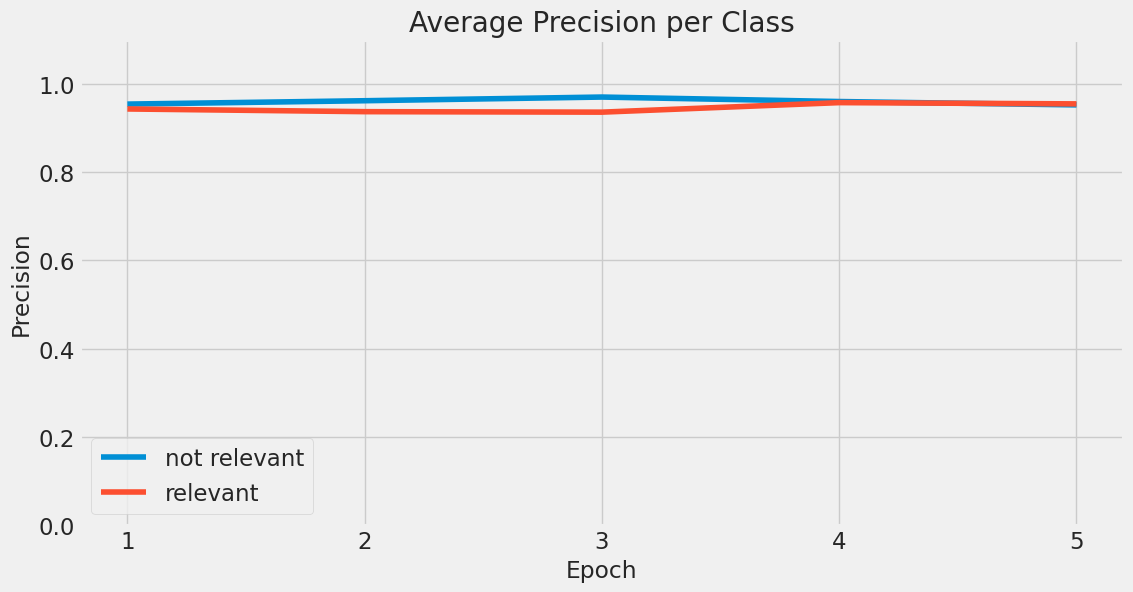

<Figure size 1200x600 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt #changes made for relevant

# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

# changes for relevance:
plt.plot(grouped0['precision'], label = "not relevant")
plt.plot(grouped1['precision'], label = "relevant")
# plt.plot(grouped0['precision'], label = "Favourable")
# plt.plot(grouped1['precision'], label = "Unfavourable")
# plt.plot(grouped2['precision'], label = "Neutral")


# Labels

plt.title("Average Precision per Class")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()

plt.show()

plt.savefig(folder_path+'2020avgprecisionclass.png', format='png', transparent = True, bbox_inches='tight')

#### No title

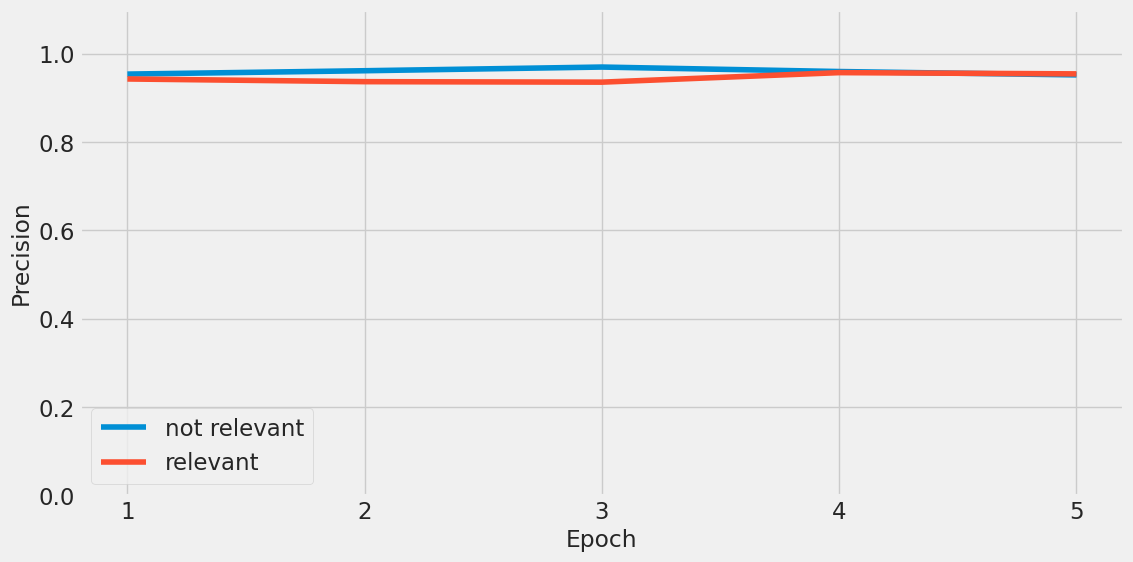

In [42]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

# changes for relevance:
plt.plot(grouped0['precision'], label = "not relevant")
plt.plot(grouped1['precision'], label = "relevant")
# plt.plot(grouped0['precision'], label = "Favourable")
# plt.plot(grouped1['precision'], label = "Unfavourable")
# plt.plot(grouped2['precision'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()

plt.savefig(folder_path+'2020avgprecisionclassnoleg.png', format='png', transparent = True, bbox_inches='tight')

### Recall

#### With Title

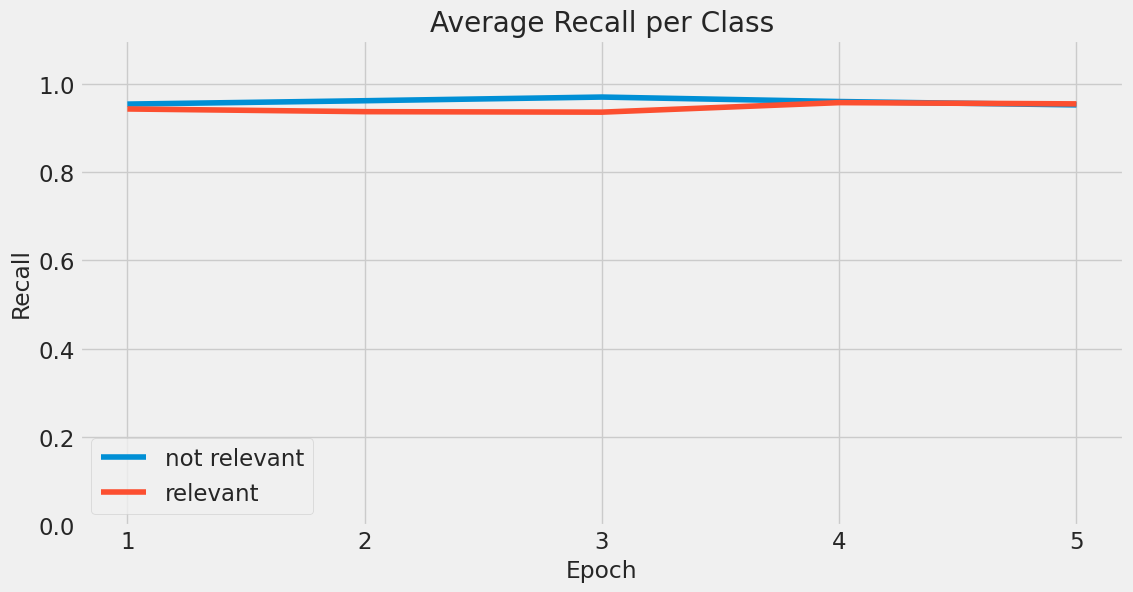

In [43]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

# changes for relevance:
plt.plot(grouped0['precision'], label = "not relevant")
plt.plot(grouped1['precision'], label = "relevant")
# plt.plot(grouped0['recall'], label = "Favourable")
# plt.plot(grouped1['recall'], label = "Unfavourable")
# plt.plot(grouped2['recall'], label = "Neutral")


# Labels

plt.title("Average Recall per Class")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()


plt.savefig(folder_path+'2020avgrecallclass.png', format='png', transparent = True, bbox_inches='tight')

#### No Title

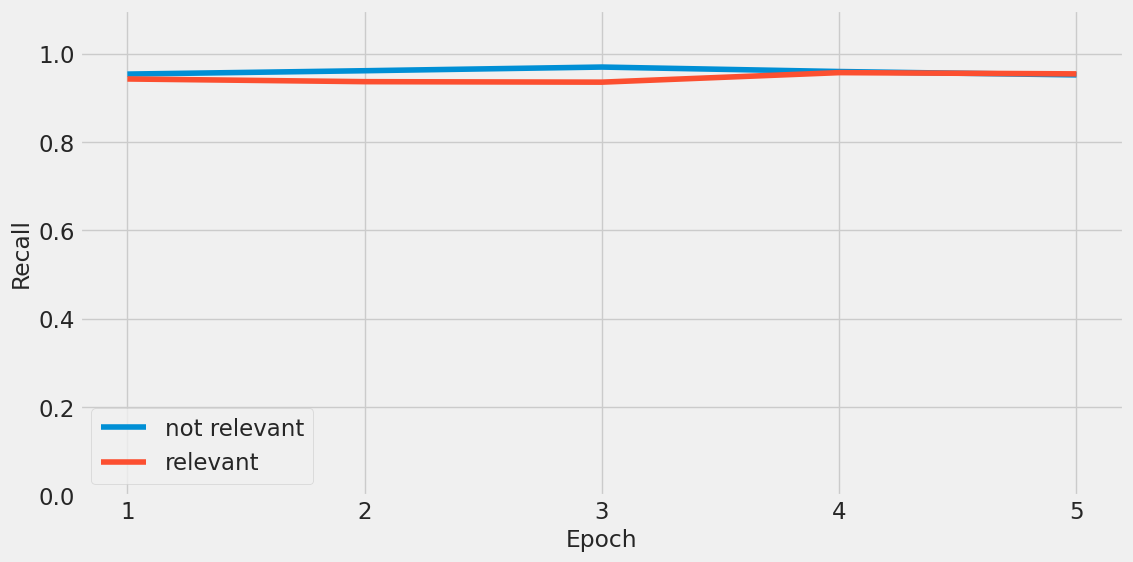

In [44]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

# changes for relevance:
plt.plot(grouped0['precision'], label = "not relevant")
plt.plot(grouped1['precision'], label = "relevant")
# plt.plot(grouped0['recall'], label = "Favourable")
# plt.plot(grouped1['recall'], label = "Unfavourable")
# plt.plot(grouped2['recall'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()



plt.savefig(folder_path+'2020avgrecallclassnoleg.png', format='png', transparent = True, bbox_inches='tight')

### F1-score

#### With Title

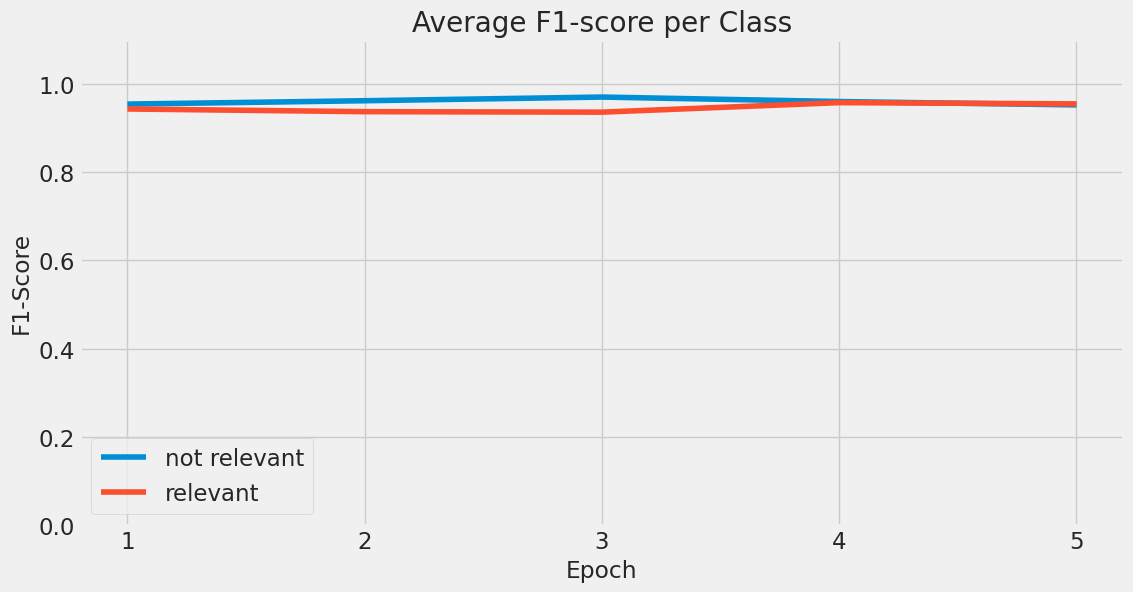

In [45]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

# changes for relevance:
plt.plot(grouped0['precision'], label = "not relevant")
plt.plot(grouped1['precision'], label = "relevant")
# plt.plot(grouped0['f1-score'], label = "Favourable")
# plt.plot(grouped1['f1-score'], label = "Unfavourable")
# plt.plot(grouped2['f1-score'], label = "Neutral")


# Labels

plt.title("Average F1-score per Class")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()


plt.savefig(folder_path+'2020avgf1class.png', format='png', transparent = True, bbox_inches='tight')

#### No Title

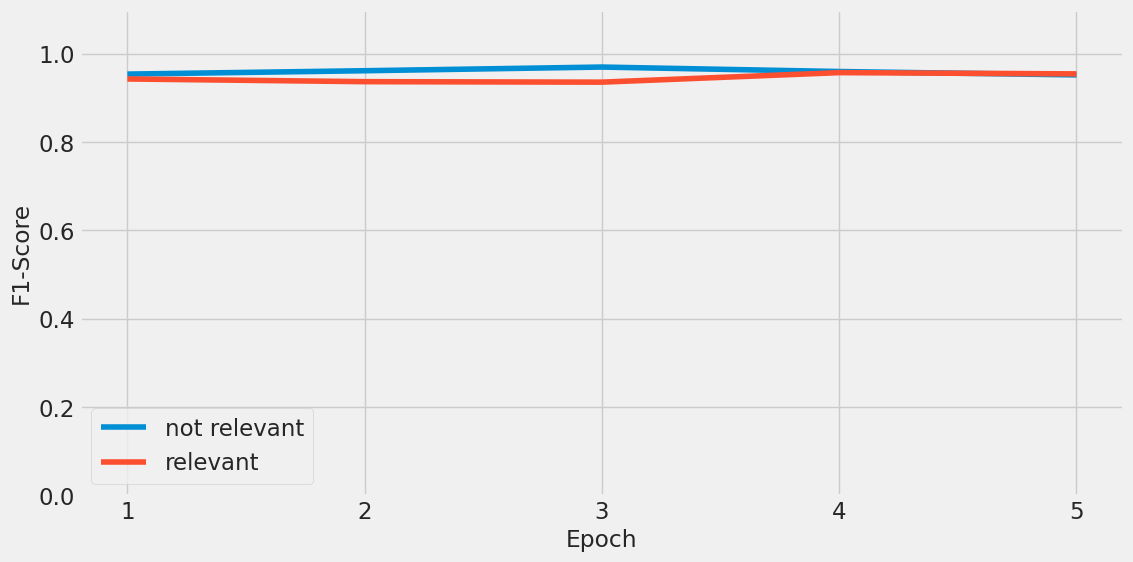

In [46]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

# changes for relevance:
plt.plot(grouped0['precision'], label = "not relevant")
plt.plot(grouped1['precision'], label = "relevant")
# plt.plot(grouped0['f1-score'], label = "Favourable")
# plt.plot(grouped1['f1-score'], label = "Unfavourable")
# plt.plot(grouped2['f1-score'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()



plt.savefig(folder_path+'2020avgf1classnoleg.png', format='png', transparent = True, bbox_inches='tight')

### Loss

#### With Title

In [47]:
# Plot styling

sns.set(style = "darkgrid")

# Aumenttndo o tamanho do plot e da fonte

sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = (12,6)

# Curva de aprendizado

treino_loss = df_stats.groupby('epoch')['Training Loss'].mean()
valida_loss = df_stats.groupby('epoch')['Valid. Loss'].mean()

treino_valid = pd.merge(treino_loss, valida_loss, right_index = True,
               left_index = True)


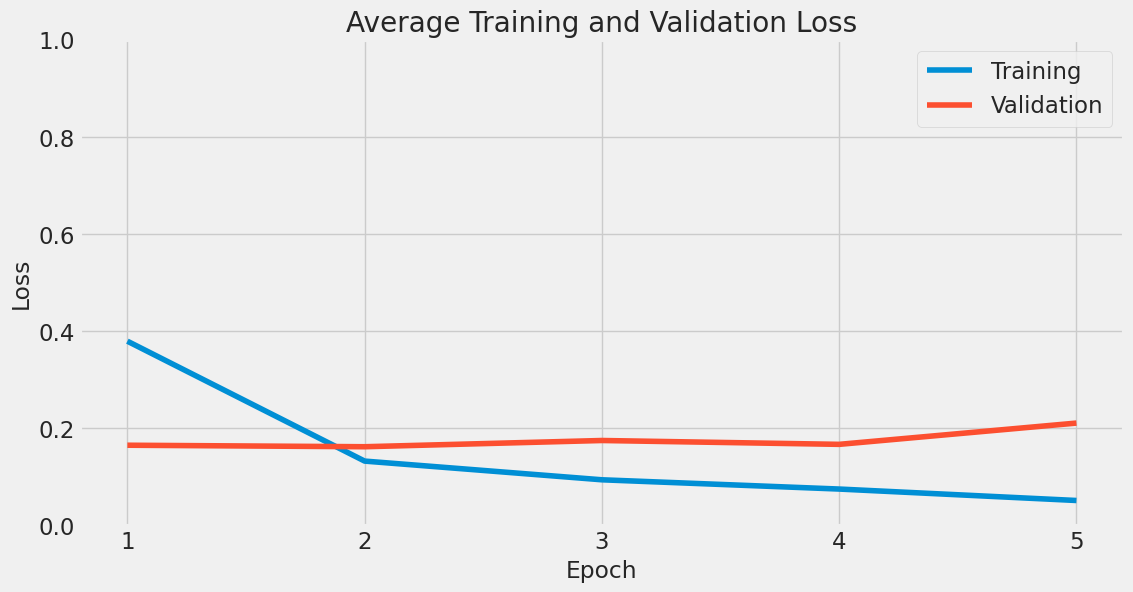

In [48]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')



plt.plot(treino_valid['Training Loss'], label = "Training")
plt.plot(treino_valid['Valid. Loss'], label = "Validation")

# Labels

plt.title("Average Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))



plt.savefig(folder_path+'2020avgloss.png', format='png', transparent = True, bbox_inches='tight')

# import matplotlib.pyplot as plt

# plt.plot(treino_valid['Training Loss'], 'b-o', label = "Training")
# plt.plot(treino_valid['Valid. Loss'], 'g-o', label = "Validation")

# # Labels

# plt.title("Average Training and Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.xticks([1,2,3,4,5])
# plt.ylim((0, 1))



# plt.savefig(folder_path+'2020avgloss.png', format='png', transparent = True, bbox_inches='tight')

#### No Title

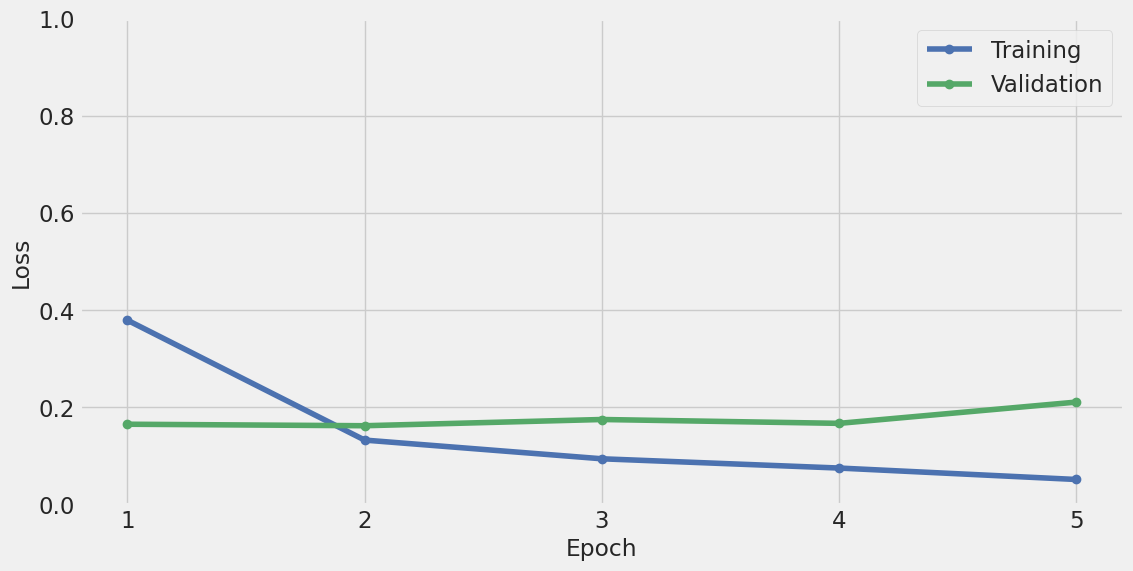

In [49]:
plt.plot(treino_valid['Training Loss'], 'b-o', label = "Training")
plt.plot(treino_valid['Valid. Loss'], 'g-o', label = "Validation")

# Labels

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))




plt.savefig(folder_path+'2020avglossnoleg.png', format='png', transparent = True, bbox_inches='tight')

## Test Set Predictions


---

In [61]:
df_test

,tweet_id,content,post_date,relevance
1056,B3816,Bolsonaro insiste em brincar com coisa séria. ...,2020-07-22,1
2088,B6222,para que não sejam retomadas as aulas presenci...,2020-04-28,0
1512,A37,Nós da oposição na Câmara vamos acionar o STF ...,2020-10-21,1
2734,B3907,Ontem no #EncontroDaEducação eu bem tratei de ...,2020-07-09,0
919,B1880,"@xomano_eu Diante disso, o Hospital do Câncer ...",2020-12-16,0
...,...,...,...,...
1582,A1347,Grande notícia! A parceria com a China na prod...,2020-08-11,1
848,A978,Cientistas são ameaçados de morte; Fiocruz con...,2020-04-17,1
1009,B4101,"Com mais 327 mortes, São Paulo bate novo recor...",2020-06-02,0
2102,B2489,"Infelizmente, em Curitiba, o tratamento precoc...",2020-09-04,1


In [62]:
test_data = TestDataset(df_test)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

In [63]:
print(len(test_dataloader))

10


In [64]:
# ========================================
#               Test Set
# ========================================

print('\nTest Set...')

model_preds_list = []

print('Total batches:', len(test_dataloader))

fold_no = 0

for fold_no in range(0, NUM_FOLDS_TO_TRAIN):

    print('\nFold Model', fold_no)

    # Load the fold model
    path_model = 'model_' + str(fold_no) + '.bin'
    model.load_state_dict(torch.load(path_model))

    # Send the model to the device.
    model.to(device)


    stacked_val_labels = []


    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    for j, h_batch in enumerate(test_dataloader):

        inference_status = 'Batch ' + str(j + 1)

        print(inference_status, end='\r')

        b_input_ids = h_batch[0].to(device)
        b_input_mask = h_batch[1].to(device)
        b_token_type_ids = h_batch[2].to(device)


        outputs = model(b_input_ids,
                token_type_ids=b_token_type_ids,
                attention_mask=b_input_mask)


        # Get the preds
        preds = outputs[0]


        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()


        # Stack the predictions.

        if j == 0:  # first batch
            stacked_val_preds = val_preds

        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))


    model_preds_list.append(stacked_val_preds)


print('\nPrediction complete.')


Test Set...
Total batches: 10

Fold Model 0
Batch 10
Fold Model 1
Batch 10
Fold Model 2
Batch 10
Fold Model 3
Batch 10
Fold Model 4
Batch 10
Prediction complete.


In [65]:
model_preds_list

[array([[-2.1357346 ,  2.2936897 ],
        [ 2.1872196 , -2.1176424 ],
        [-2.2205102 ,  2.4584246 ],
        [ 2.179021  , -2.2840235 ],
        [ 2.2484565 , -2.4247198 ],
        [ 2.3609762 , -2.4457207 ],
        [ 2.309489  , -2.3302076 ],
        [ 2.025085  , -1.9523492 ],
        [-2.2108998 ,  2.4414556 ],
        [ 2.236348  , -2.4377847 ],
        [ 2.5409553 , -2.5906196 ],
        [ 1.7095993 , -1.7030557 ],
        [-0.79043144,  0.58092314],
        [ 2.369497  , -2.3931231 ],
        [-1.9343522 ,  2.1604583 ],
        [ 0.5575668 , -0.47297403],
        [ 2.1296573 , -2.0130205 ],
        [-1.7868216 ,  1.9690346 ],
        [-2.212492  ,  2.386262  ],
        [ 2.3801584 , -2.442286  ],
        [-1.511061  ,  1.6417581 ],
        [ 2.249706  , -2.4013886 ],
        [ 2.225864  , -2.409056  ],
        [ 2.1579862 , -2.1714911 ],
        [-2.1221142 ,  2.300494  ],
        [-2.0085723 ,  2.2173188 ],
        [-1.8899461 ,  2.136098  ],
        [-1.2548196 ,  1.563

### Results - Average Fold Results

Here are the results using the average prediction over all folds.

In [66]:
# Take the argmax. This returns the column index of the max value in each row.

# Sum the predictions of all fold models
for i, item in enumerate(model_preds_list):

    if i == 0:

        preds = item

    else:

        # Sum the matrices
        preds = item + preds


# Average the predictions
avg_preds = preds/(len(model_preds_list))


test_preds = np.argmax(avg_preds, axis=1)

In [67]:
# changes for relevant:
accuracy_score(df_test[RELEVANCE], test_preds)
# accuracy_score(df_test['positions_vac'], test_preds)

0.9501661129568106

In [69]:
# changes for relevant:
print(classification_report(df_test[RELEVANCE], test_preds, labels = [0,1]))
# print(classification_report(df_test['positions_vac'], test_preds, labels = [0,1,2]))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       160
           1       0.93      0.97      0.95       141

    accuracy                           0.95       301
   macro avg       0.95      0.95      0.95       301
weighted avg       0.95      0.95      0.95       301



In [70]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy

# changes for relevant:
confusion_matrix = metrics.confusion_matrix(df_test[RELEVANCE], test_preds)
# confusion_matrix = metrics.confusion_matrix(df_test['positions_vac'], test_preds)

confusion_matrix

array([[149,  11],
       [  4, 137]])

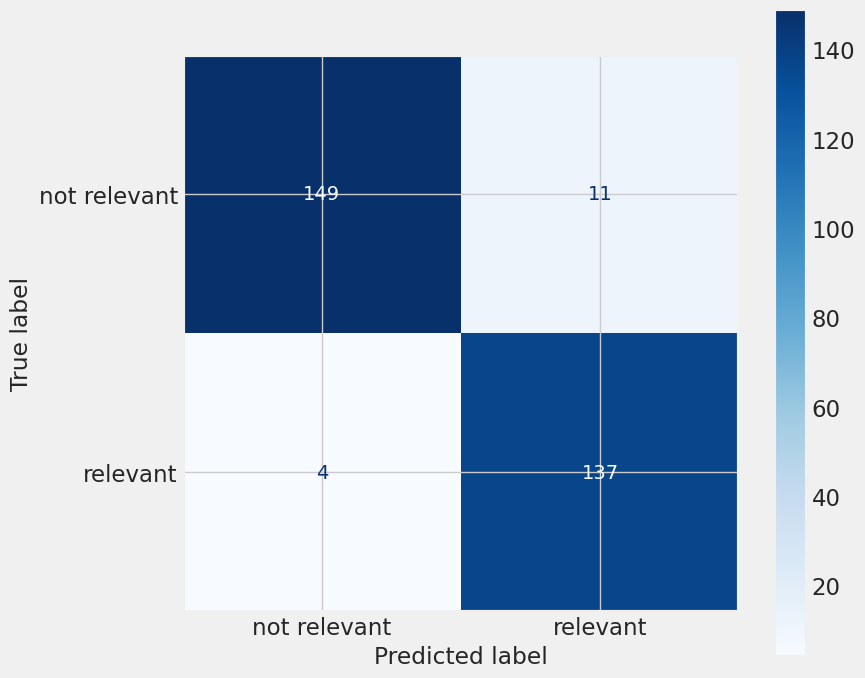

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
                  # changes for relevante
                  df_test[RELEVANCE],
                  # df_test['positions_vac'],
                  test_preds,
                  # changes for relevante
                  labels=[0,1],
                  # labels=[0,1,2],
                  cmap=plt.cm.Blues,
                  # changes for relevante
                  display_labels=['not relevant','relevant'],
                  # display_labels=['Positive','Negative', 'Neutral'],
                  values_format='',
)
fig = disp.ax_.get_figure()
fig.set_figwidth(8)
fig.set_figheight(8)

### Best Fold Results

---



Below are the results of the predictions of the best model alone.

In [72]:
# Summary of the Training Process

pd.set_option('display.precision', 2)

# Creating a dataframe with our training results

df_stats = pd.DataFrame(data = training_stats)

# Using Epoch as an index

df_stats = df_stats.set_index('fold')

# Getting the Fold with the best F1-Macro

bestsplit = df_stats['macro_f1_score'].idxmax()

df_stats['macro_f1_score'].idxmax()

1

In [73]:
# Take the argmax. This returns the column index of the max value in each row.

# Sum the predictions of all fold models
for i, item in enumerate(model_preds_list):

    if i == bestsplit:
        preds_bestsplit = item


bestsplit_preds = np.argmax(preds_bestsplit, axis=1)

In [74]:
# changes for relevante:
accuracy_score(df_test[RELEVANCE], bestsplit_preds)
# accuracy_score(df_test['positions_vac'], bestsplit_preds)

0.9534883720930233

In [75]:
# changes for relevante:
print(classification_report(df_test[RELEVANCE], bestsplit_preds, labels = [0,1]))
# print(classification_report(df_test['positions_vac'], bestsplit_preds, labels = [0,1,2]))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       160
           1       0.94      0.96      0.95       141

    accuracy                           0.95       301
   macro avg       0.95      0.95      0.95       301
weighted avg       0.95      0.95      0.95       301



In [76]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy

# changes for relevante:
confusion_matrix = metrics.confusion_matrix(df_test[RELEVANCE], bestsplit_preds)
# confusion_matrix = metrics.confusion_matrix(df_test['positions_vac'], bestsplit_preds)

confusion_matrix

array([[151,   9],
       [  5, 136]])

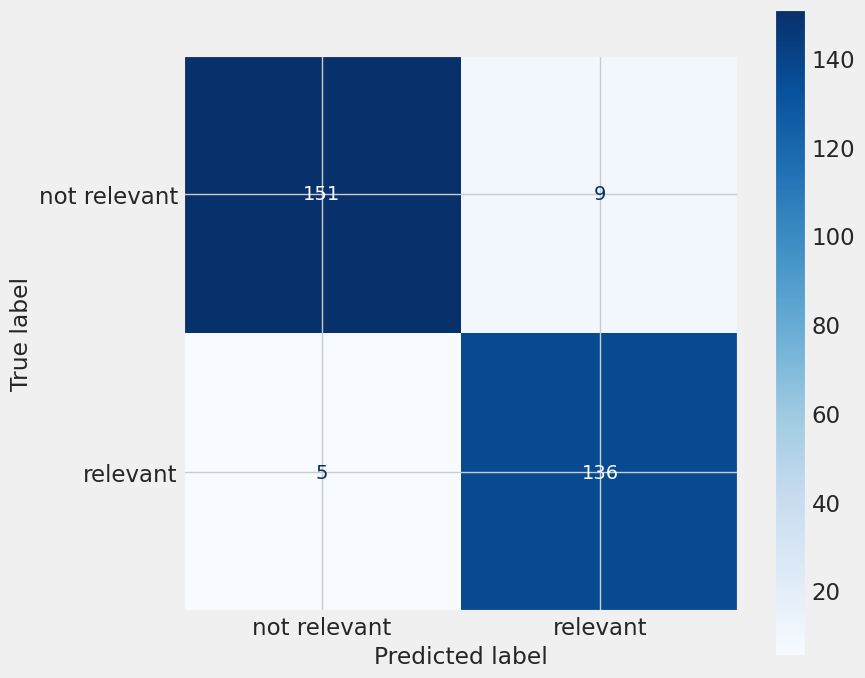

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
                  # changes for relevante
                  df_test[RELEVANCE],
                  # df_test['positions_vac'],
                  bestsplit_preds,

                  # changes for relevante
                  labels=[0,1],
                  # labels=[0,1,2],
                  cmap=plt.cm.Blues,
                  # changes for relevante
                  display_labels=['not relevant','relevant'],
                  # display_labels=['Positive','Negative', 'Neutral'],
                  values_format='',
)
fig = disp.ax_.get_figure()
fig.set_figwidth(8)
fig.set_figheight(8)